In [55]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt

# --- Load POS tags with attributes ---
with open("pos_tags.json", "r", encoding="utf-8") as f:
    pos_tags = json.load(f)


# --- Create graph ---
G = nx.Graph()

# --- Load edge list ---
G = nx.read_edgelist("cooccurrence_pairs_window2.txt", delimiter="\t")

# --- Add node attributes from pos_tags ---
for node in G.nodes():
    if node in pos_tags:
        G.nodes[node]["pos"] = pos_tags[node].get("pos")
        G.nodes[node]["gender"] = pos_tags[node].get("gender")
    else:
        G.nodes[node]["pos"] = None
        G.nodes[node]["gender"] = None



In [56]:
print(G.number_of_edges())
print(G.number_of_nodes())

105982
28483


In [57]:
degree_centrality = nx.degree_centrality(G)

# Get node with maximum centrality
max_degree_node = max(degree_centrality, key=degree_centrality.get)

node_name = max_degree_node  
node_attrs = G.nodes[max_degree_node]

print(f"Node with highest degree centrality: {node_name}")
print(f"Centrality: {degree_centrality[max_degree_node]}")
print(f"Attributes: {node_attrs}")


Node with highest degree centrality: find
Centrality: 0.018011375605645672
Attributes: {'pos': 'VERB', 'gender': None}


Text(0, 0.5, 'Frequency')

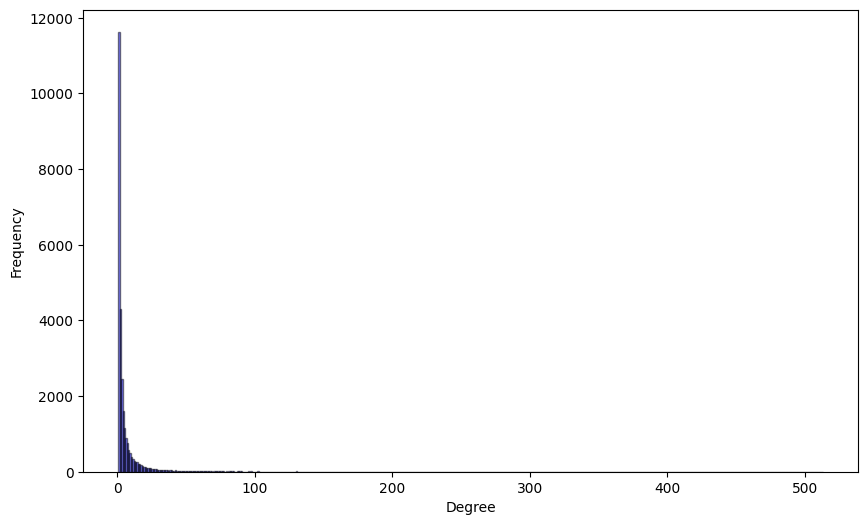

In [58]:
degree = dict(G.degree())
min_degree, max_degree = min(degree.values()), max(degree.values())
degree_vector = np.arange(min_degree, max_degree + 1)
degree_hist = np.histogram(list(degree.values()), bins=degree_vector)

plt.figure(figsize=(10, 6))
plt.hist(degree.values(), bins=degree_hist[1], color='blue', alpha=0.5, edgecolor='black')
# plt.title('Degree Distribution', size=40)
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [59]:
sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]

[('find', 513),
 ('take\r', 492),
 ('find\r', 481),
 ('take', 437),
 ('return\r', 391),
 ('leave\r', 361),
 ('return', 360),
 ('leave', 358),
 ('make\r', 350),
 ('name', 350)]

<BarContainer object of 4 artists>

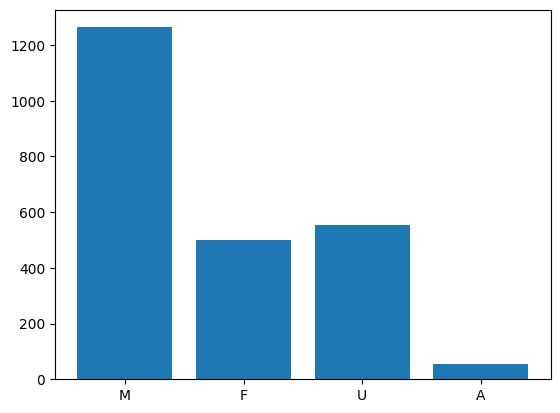

In [60]:
# Get gender of nodes
genders_in_graph = [G.nodes[node]["gender"] for node in G.nodes() if G.nodes[node]["gender"] is not None]
dict_ = {}
for gender in genders_in_graph:
    if gender not in dict_:
        dict_[gender] = 1
    else:
        dict_[gender] += 1

# Plot gender distribution
plt.bar(dict_.keys(), dict_.values())

In [61]:
for node in G.nodes:
    if G.nodes[node]['gender'] == 'A':
        print(node)

Adam
Mei
Amit
Jill
Teo
Tremaine
Deja
Tremain
Tail
Winnie
Kozak
Davie
Callaghan
merry
Traske
Stella
Dawson
Forrester
Kane
Habib
Tala
Bobbi
Binx
Otterton
Muff
Mills
Harper
Lawless
Pruitt
Framm
Beauty
Fitzpatrick
Hooper
Chet
Judson
Flaversham
Brydon
Milky
Mutt
Alexis
Haru
Myers
Favers
O'Donnell
Judd
Baba
Pei
Popo
Callisto
Potato
Edmunds
muff
Tyrannosaurus
Basset
Nixon
